In [1]:
from getpass import getpass
from glob import glob

import numpy as np
import pylab as plt
from astropy import stats, units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve
from statistics import median

from scipy.optimize import curve_fit, least_squares

import utils

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# plotting setup
fontsize = 14
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize

In [2]:
import var
from astropy.io import fits

12:24:28.77, -31:55:27.0

In [3]:
objname = '150023_1179'
star=qc.query(sql="""SELECT meas.* 
                     FROM nsc_dr2.meas
                     WHERE objectid='{:s}'""".format(objname),
              fmt='pandas',
              profile='db01')
star[:5]

,mjd,ra,dec,x,y,raerr,decerr,mag_auto,magerr_auto,mag_aper1,...,theta,thetaerr,fwhm,class_star,ccdnum,flags,measid,objectid,exposure,filter
0,57113.103622,184.660012,-31.714284,1925.4500,3753.07,0.013498,0.012326,16.4367,0.002352,17.5287,...,102.5060,16.88590,1.015290,0.988802,19,0,c4d.426837.19.111,150023_1179,c4d_150401_023233_ooi_r_v1,r
1,57113.056146,184.660014,-31.714282,1916.1600,3738.60,0.017272,0.014770,16.6075,0.002451,17.7974,...,94.8063,-2.10764,1.093830,0.983845,19,0,c4d.426814.19.143,150023_1179,c4d_150401_012411_ooi_i_v1,i
2,57112.054908,184.660013,-31.714283,1910.2000,3754.76,0.014560,0.011941,16.6778,0.002346,17.9072,...,82.5395,-81.96120,1.143730,0.988209,19,0,c4d.426474.19.118,150023_1179,c4d_150331_012224_ooi_r_v1,r
3,56736.267460,184.660019,-31.714281,561.9940,1717.94,0.018848,0.017301,16.7528,0.013090,17.7609,...,149.2020,-55.76460,0.960298,0.983257,19,0,c4d.294386.19.444,150023_1179,c4d_140320_062622_ooi_Y_v1,Y
4,57100.221888,184.660015,-31.714279,38.7759,2497.93,0.013784,0.014180,16.9189,0.007564,17.9516,...,165.4620,-61.81470,0.998975,0.990544,46,0,c4d.423324.46.763,150023_1179,c4d_150319_052119_ooi_r_v1,r


In [4]:
def get_data(df,band='r ',aper=1):
    fltr = (df['filter'] == band)
    fwhm = (df['fwhm'] <= 4.0)
    sel = fltr & fwhm
    #sel = (df['filter'] == band)
    t = df['mjd'][sel].values
    y = df['mag_auto'][sel].values
    dy = df['magerr_auto'][sel].values
    return t,y,dy # return time, magnitudes in one band, uncertainties

def get_ls_periodogram(t,y,min_freq=1./1.,max_freq=1./0.1):
    
    """Compute Lomb-Scargle periodogram.
    
    Parameters
    ----------
    t : array
        Observation time array (e.g. MJD), ordered in ascending order.
    
    y : array
        Magnitude measurements at times ``t``.
        
    min_freq, max_freq : float or None
        The period finder can be guided by providing the min and max frequency
        in the ``y`` signal, in units 1/t. 
          min_freq = 1/longest expected period (in days)
          max_freq = 1/shortest expected perdiod (in days)
        The defaults are typical for RR Lyrae variability (RR Lyrae usually
        have a period of a fraction of one day).
        
    Returns
    -------
    period : array
        Phased period of the time-variable signal (fraction of the phase).
        
    power : array
        The periodogramm power as function if ``period``.
        
    """
    
    # Use astropy's LombScargle class
    ls = stats.LombScargle(t, y)

    # Compute the periodogram
    #   We guide the algorithm a bit:
    #     min_freq = 1/longest expected period (in days)
    #     max_freq = 1/shortest expected perdiod (in days)
    #   RR Lyrae usually have a period of a fraction of one day
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)
    period = 1./frequency # period is the inverse of frequency
    
    return period, power


def get_best_period(period,power):
    
    """Return the period with highest power."""
    
    return period[np.argmax(power)]

def get_folded_phase(t,best_period,offset=0):
    
    """Fold the observation times with the best period of the variable signal."""
    
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = t % best_period - offset
    
    return phase

def plot_periodogram(period,power,best_period=None,title='',ax=None):

    """Plot a periodogram.
    
    Parameters
    ----------
    
    period, power : array
        The period and power 1-d arrays as returned by :func:`get_ls_periodogram()`
    
    best_period : float or None
        If float, the value of this ``best_period`` will be marked in the plot.
    
    title : str
        Title of the figure. Default: ''.
    
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    ax.plot(period,power,lw=0.1)
    ax.set_xlabel('period (days)')
    ax.set_ylabel('relative power')
    ax.set_title(title)
    
    if best_period is not None:
        ax.axvline(best_period,color='r');
        ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')

def smooth(x,y,s=80):
    """
    Convolves with a gaussian to create a smoothe line.
    """
    f = interp1d(x,y)
    xx = np.linspace(min(x),max(x),2000)
    yy = f(xx)
    window = gaussian(200,s)
    smoothed = convolve(yy, window/window.sum(), mode='same')
    return xx,smoothed

In [5]:
import collections
collections.Counter(star['filter'])

Counter({'r': 64, 'i': 61, 'Y': 3, 'g': 73, 'z': 10, 'u': 10})

0.5982037542845634

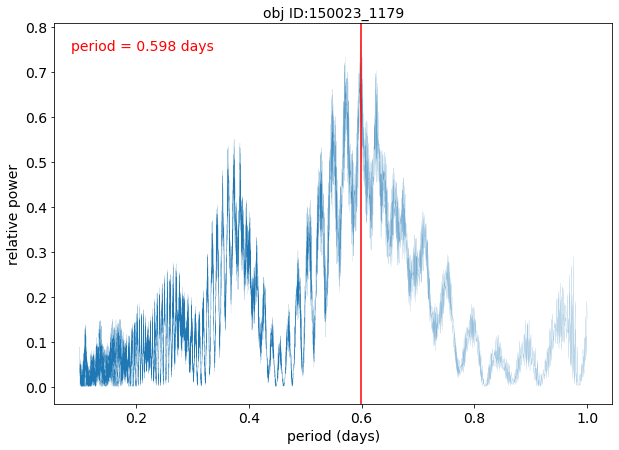

In [6]:
tr,yr,dyr = get_data(star,'r')
tg,yg,dyg = get_data(star,'g')
ti,yi,dyi = get_data(star,'i')

period_r, power_r = get_ls_periodogram(tr,yr)
best_period_r = get_best_period(period_r,power_r)

period_g, power_g = get_ls_periodogram(tg,yg)
best_period_g = get_best_period(period_g,power_g)

period_i, power_i = get_ls_periodogram(ti,yi)
best_period_i = get_best_period(period_i,power_i)

best_period = ( best_period_r + best_period_g + best_period_i ) / 3

plot_periodogram(period_r,power_r,best_period_r,title='obj ID:{}'.format(objname))


period = best_period
display(best_period)

gcrv = np.vstack((tg,yg-min(yg),dyg)).T
rcrv = np.vstack((tr,yr-min(yr),dyr)).T
icrv = np.vstack((ti,yi-min(yi),dyi)).T

crv = [gcrv,rcrv,icrv]

In [7]:
templets=[glob('templets/*g.dat'),glob('templets/*r.dat'),glob('templets/*i.dat')]
gtmps = np.zeros((len(templets[0]),501,2))
for i in range(len(templets[0])):
    gtmps[i] = np.concatenate((np.array([[0,0]]),
                               np.array(pd.read_csv(templets[0][i],sep=' ')),
                               np.array([[1,0]])))
rtmps = np.zeros((len(templets[1]),501,2))
for i in range(len(templets[1])):
    rtmps[i] = np.concatenate((np.array([[0,0]]),
                               np.array(pd.read_csv(templets[1][i],sep=' ')),
                               np.array([[1,0]])))
itmps = np.zeros((len(templets[2]),501,2))
for i in range(len(templets[2])):
    itmps[i] = np.concatenate((np.array([[0,0]]),
                               np.array(pd.read_csv(templets[2][i],sep=' ')),
                               np.array([[1,0]])))
tmps = [gtmps,rtmps,itmps]

In [8]:
class tmpfitter:
    def __init__ (self, tmps):
        self.fltr=0
        self.n=0
        self.tmps=tmps

    def model(self, t, t0, amplitude, yoffset):
        # modify the template using peak-to-peak amplitude, yoffset
        # fold input times t by period, phase shift to match template
        xtemp = self.tmps[self.fltr][self.n,:,0]
        ytemp = self.tmps[self.fltr][self.n,:,1]*amplitude + yoffset
        ph = (t - t0) %1
        #print((ph[0],period,t0%1))
        #print((period,t0,amplitude,yoffset))
        # interpolate the modified template to the phase we want
        return interp1d(xtemp,ytemp)(ph)


def tmpfit(tmps,crv,pinit,steps=101):
    datfit = np.zeros((steps))
    npars = np.zeros((steps,3,4))
    fitter = tmpfitter(tmps)
    plist = np.linspace(pinit[-1]-.1,pinit[-1]+.1,steps)
    piter=0
    for p in plist:
        for f in range(len(tmps)):
            fitter.fltr = f
            phase = crv[f][:,0]/p%1
            fpars = [0,0,0,0]
            minit = 0
            minx2 = 10**20
            for i in range(len(tmps[f])):
                fitter.n = i
                try:
                    pars, cov = curve_fit(fitter.model, phase, crv[f][:,1], 
                                          bounds = ((-np.inf,0,-np.inf),np.inf),
                                          sigma=crv[f][:,2], p0=pinit[f], maxfev=5000)
                except RuntimeError:
                    print('Error: Curve_fit failed on templet={}-{}, p={:.4}'.format(fltr,i,p))
                    break
                
                x2 = sum((fitter.model(phase,pars[0],pars[1],pars[2])-crv[f][:,1])**2/crv[f][:,2])
                if x2 < minx2:
                    fpars = pars
                    minit = i
                    minx2 = x2
            npars[piter,f] = np.append(pars,minit)
            datfit[piter] += x2
        piter += 1
    n = datfit.argmin()
    return plist[n], npars[n]

In [9]:
g0=min(gcrv[:,1])
g1=max(gcrv[:,1])
r0=min(rcrv[:,1])
r1=max(rcrv[:,1])
i0=min(icrv[:,1])
i1=max(icrv[:,1])
pinit = ((0,g1-g0,g0),(0,r1-r0,r0),(0,i1-i0,i0),period)
p,pars = tmpfit(tmps,crv,pinit)
print('Period: {:.4}'.format(p))
print('g: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars[0]))
print('r: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars[1]))
print('i: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars[2]))

Period: 0.6002
g: Templet #22, Phase: 0.2022, Amp: 0.7753,  YOffset: 0.0336
r: Templet #18, Phase: 0.2239, Amp: 0.5015,  YOffset: 0.03944
i: Templet #17, Phase: 0.2103, Amp: 0.4175,  YOffset: 0.01941


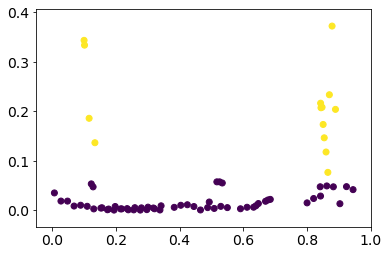

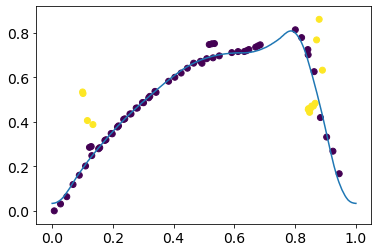

In [10]:
fltr = 0
n = pars[:,-1].astype(int)
f = interp1d(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars[fltr,1]+pars[fltr,2])
phase = (crv[fltr][:,0]/p-pars[fltr,0]) %1
dif=[]
dif.append(abs(crv[fltr][:,1]-f(phase)))
plt.figure()
plt.scatter(phase,dif[fltr],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.figure()
plt.scatter(phase,crv[fltr][:,1],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.plot(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars[fltr,1]+pars[fltr,2])

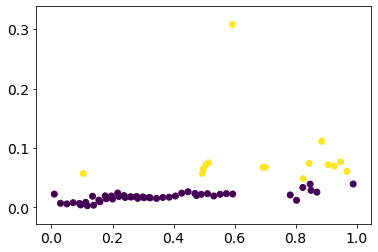

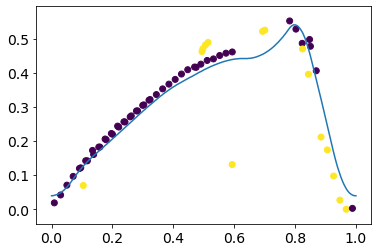

In [11]:
fltr = 1
n = pars[:,-1].astype(int)
f = interp1d(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars[fltr,1]+pars[fltr,2])
phase = (crv[fltr][:,0]/p-pars[fltr,0]) %1
dif.append(abs(crv[fltr][:,1]-f(phase)))
plt.figure()
plt.scatter(phase,dif[fltr],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.figure()
plt.scatter(phase,crv[fltr][:,1],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.plot(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars[fltr,1]+pars[fltr,2])

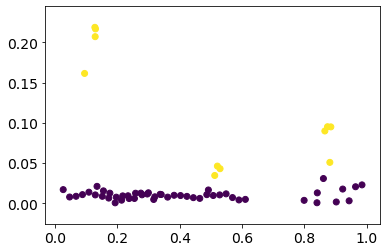

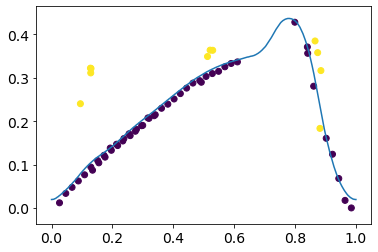

In [12]:
fltr = 2
n = pars[:,-1].astype(int)
f = interp1d(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars[fltr,1]+pars[fltr,2])
phase = (crv[fltr][:,0]/p-pars[fltr,0]) %1
dif.append(abs(crv[fltr][:,1]-f(phase)))
plt.figure()
plt.scatter(phase,dif[fltr],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.figure()
plt.scatter(phase,crv[fltr][:,1],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.plot(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars[fltr,1]+pars[fltr,2])

In [13]:
crv_in = []
crv_in.append(crv[0][dif[0]<utils.mad(dif[0])*5])
crv_in.append(crv[1][dif[1]<utils.mad(dif[1])*5])
crv_in.append(crv[2][dif[2]<utils.mad(dif[2])*5])

In [14]:
pinit = (pars[0,:-1],pars[1,:-1],pars[2,:-1],p)
p_in, pars_in = tmpfit(tmps, crv_in, pinit)
print('Old:')
print('Period: {:.4}'.format(p))
print('g: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars[0]))
print('r: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars[1]))
print('i: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars[2]))
print('New:')
print('Period: {:.4}'.format(p_in))
print('g: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars_in[0]))
print('r: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars_in[1]))
print('i: Templet #{3:.0f}, Phase: {0:.4}, Amp: {1:.4},  YOffset: {2:.4}'.format(*pars_in[2]))

Error: Curve_fit failed on templet=2-12, p=0.5122037542845634
Error: Curve_fit failed on templet=2-12, p=0.5342037542845635
Old:
Period: 0.6002
g: Templet #22, Phase: 0.2022, Amp: 0.7753,  YOffset: 0.0336
r: Templet #18, Phase: 0.2239, Amp: 0.5015,  YOffset: 0.03944
i: Templet #17, Phase: 0.2103, Amp: 0.4175,  YOffset: 0.01941
New:
Period: 0.6002
g: Templet #17, Phase: 0.2054, Amp: 0.7887,  YOffset: 0.02798
r: Templet #19, Phase: 0.2266, Amp: 0.4965,  YOffset: 0.0491
i: Templet #21, Phase: 0.2115, Amp: 0.4244,  YOffset: 0.01238


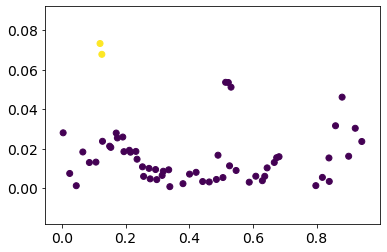

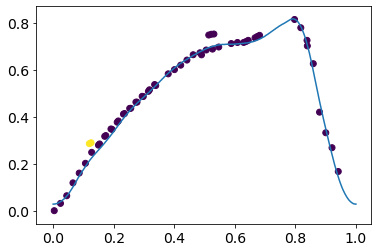

In [15]:
fltr = 0
n = pars_in[:,-1].astype(int)
f = interp1d(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars_in[fltr,1]+pars_in[fltr,2])
phase_in = (crv_in[fltr][:,0]/p_in-pars_in[fltr,0]) %1
dif=[]
dif.append(abs(crv_in[fltr][:,1]-f(phase_in)))
plt.figure()
plt.scatter(phase_in,dif[fltr],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.figure()
plt.scatter(phase_in,crv_in[fltr][:,1],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.plot(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars_in[fltr,1]+pars_in[fltr,2])

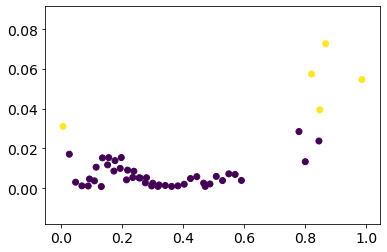

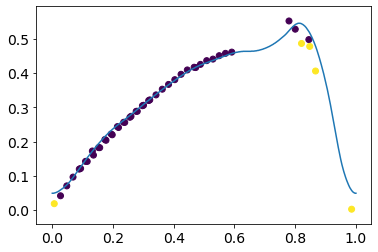

In [16]:
fltr = 1
n = pars_in[:,-1].astype(int)
f = interp1d(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars_in[fltr,1]+pars_in[fltr,2])
phase_in = (crv_in[fltr][:,0]/p_in-pars_in[fltr,0]) %1
dif.append(abs(crv_in[fltr][:,1]-f(phase_in)))
plt.figure()
plt.scatter(phase_in,dif[fltr],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.figure()
plt.scatter(phase_in,crv_in[fltr][:,1],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.plot(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars_in[fltr,1]+pars_in[fltr,2])

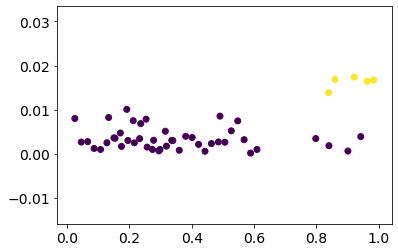

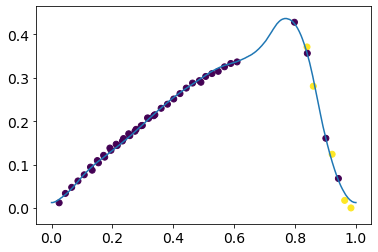

In [17]:
fltr = 2
n = pars_in[:,-1].astype(int)
f = interp1d(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars_in[fltr,1]+pars_in[fltr,2])
phase_in = (crv_in[fltr][:,0]/p_in-pars_in[fltr,0]) %1
dif.append(abs(crv_in[fltr][:,1]-f(phase_in)))
plt.figure()
plt.scatter(phase_in,dif[fltr],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.figure()
plt.scatter(phase_in,crv_in[fltr][:,1],c=dif[fltr]>utils.mad(dif[fltr])*5)
plt.plot(tmps[fltr][n[fltr],:,0],tmps[fltr][n[fltr],:,1]*pars_in[fltr,1]+pars_in[fltr,2])

In [18]:
def

SyntaxError: invalid syntax (<ipython-input-18-7b18d017f89f>, line 1)

In [ ]:
crv2 = []
crv2.append(crv_in[0].copy())

In [ ]:
gcrv2 = gcrv.copy()
rcrv2 = rcrv.copy()
icrv2 = icrv.copy()

gcrv2[:,0] = (gcrv2[:,0]-gpars[1])/gpars[0]%1
gcrv2 = np.tile(gcrv2.T,2).T
gcrv2[int(len(gcrv2)/2):,0] += 1
gcrv2 = gcrv2[gcrv2[:,0].argsort()]

rcrv2[:,0] = (rcrv2[:,0]-rpars[1])/rpars[0]%1
rcrv2 = np.tile(rcrv2.T,2).T
rcrv2[int(len(rcrv2)/2):,0] += 1
rcrv2 = rcrv2[rcrv2[:,0].argsort()]

icrv2[:,0] = (icrv2[:,0]-ipars[1])/ipars[0]%1
icrv2 = np.tile(icrv2.T,2).T
icrv2[int(len(icrv2)/2):,0] += 1
icrv2 = icrv2[icrv2[:,0].argsort()]

gtemplets2 = np.tile(gtemplets,(2,1))
gtemplets2[:,int(len(gtemplets2[0])/2):,0] += 1
rtemplets2 = np.tile(rtemplets,(2,1))
rtemplets2[:,int(len(rtemplets2[0])/2):,0] += 1
itemplets2 = np.tile(itemplets,(2,1))
itemplets2[:,int(len(itemplets2[0])/2):,0] += 1


In [ ]:
f = interp1d(gtemplets2[gn,:,0],gtemplets2[gn,:,1]*gpars[2]+gpars[3])
difg = abs(gcrv2[:,1]-f(gcrv2[:,0]))
plt.scatter(gcrv2[:,0],difg,c=difg>utils.mad(difg)*5)

In [ ]:
plt.plot(gtemplets2[gn,:,0],gtemplets2[gn,:,1]*gpars[2]+gpars[3],c='g')
plt.scatter(gcrv2[:,0],gcrv2[:,1],c=difg>utils.mad(difg)*5)

In [ ]:
f = interp1d(rtemplets2[rn,:,0],rtemplets2[rn,:,1]*rpars[2]+rpars[3])
difr = abs(rcrv2[:,1]-f(rcrv2[:,0]))
plt.scatter(rcrv2[:,0],difr,c=difr>utils.mad(difr)*5)

In [ ]:
plt.plot(rtemplets2[rn,:,0],rtemplets2[rn,:,1]*rpars[2]+rpars[3],c='r')
plt.scatter(rcrv2[:,0],rcrv2[:,1],c=difr>utils.mad(difr)*5)

In [ ]:
f = interp1d(itemplets2[ni,:,0],itemplets2[ni,:,1]*ipars[2]+ipars[3])
difi = abs(icrv2[:,1]-f(icrv2[:,0]))
plt.scatter(icrv2[:,0],difi,c=difi>utils.mad(difi)*5)

In [ ]:
plt.plot(itemplets2[ni,:,0],itemplets2[ni,:,1]*ipars[2]+ipars[3],c='b')
plt.scatter(icrv2[:,0],icrv2[:,1],c=difi>utils.mad(difi)*5)

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

gshft = 0
rshft = .9
ishft = 1.6

ax.plot(gtemplets2[gn,:,0],gtemplets2[gn,:,1]*gpars[2] + gpars[3]+gshft,c='black')
ax.plot(rtemplets2[rn,:,0],rtemplets2[rn,:,1]*rpars[2] + rpars[3]+rshft,c='black')
ax.plot(itemplets2[ni,:,0],itemplets2[ni,:,1]*ipars[2] + ipars[3]+ishft,c='black')

ax.errorbar(gcrv2[:,0],gcrv2[:,1]+gshft,yerr=gcrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='g',alpha=.6)
ax.errorbar(rcrv2[:,0],rcrv2[:,1]+rshft,yerr=rcrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='r',alpha=.6)
ax.errorbar(icrv2[:,0],icrv2[:,1]+ishft,yerr=icrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='b',alpha=.6)

ax.text(0,gshft+.3,'g',fontsize=18,color='g')
ax.text(0,rshft+.3,'r',fontsize=18,color='r')
ax.text(0,ishft+.3,'i',fontsize=18,color='b')

ax.set_title('Objectid: {}     P: {:.4f} d     Type: RRab'.format(objname,period2), fontsize=20)
ax.invert_yaxis()
ax.set_xlabel('Phase', fontsize=16)
ax.set_ylabel('Relative Magnitude', fontsize=16);

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

gshft = 0
rshft = .9
ishft = 1.6

ax.plot(gtemplets2[gn_in,:,0],gtemplets2[gn_in,:,1]*gpars_in[2] + gpars_in[3]+gshft,c='black')
ax.plot(rtemplets2[rn_in,:,0],rtemplets2[rn_in,:,1]*rpars_in[2] + rpars_in[3]+rshft,c='black')
ax.plot(itemplets2[ni_in,:,0],itemplets2[ni_in,:,1]*ipars_in[2] + ipars_in[3]+ishft,c='black')

ax.errorbar(gcrv2[:,0],gcrv2[:,1]+gshft,yerr=gcrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='g',alpha=.6)
ax.errorbar(rcrv2[:,0],rcrv2[:,1]+rshft,yerr=rcrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='r',alpha=.6)
ax.errorbar(icrv2[:,0],icrv2[:,1]+ishft,yerr=icrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='b',alpha=.6)

ax.text(0,gshft+.3,'g',fontsize=18,color='g')
ax.text(0,rshft+.3,'r',fontsize=18,color='r')
ax.text(0,ishft+.3,'i',fontsize=18,color='b')

ax.set_title('Objectid: {}     P: {:.4f} d     Type: RRab'.format(objname,period2), fontsize=20)
ax.invert_yaxis() 
ax.set_xlabel('Phase', fontsize=16)
ax.set_ylabel('Relative Magnitude', fontsize=16);